<a href="https://colab.research.google.com/github/MouniriOuma/Lung-cancer-segmentation/blob/main/lung_cancer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

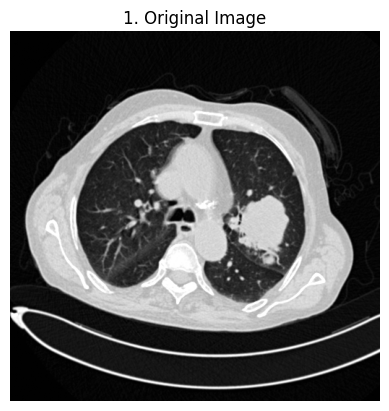

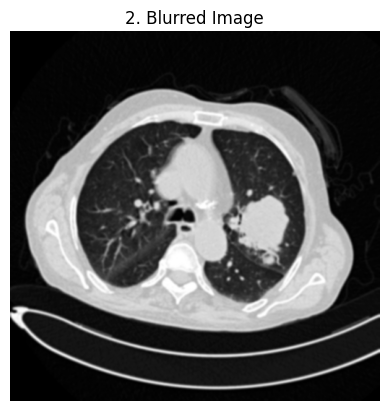

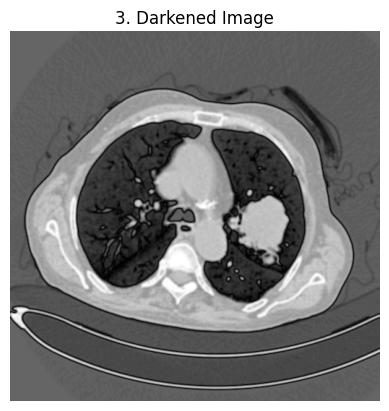

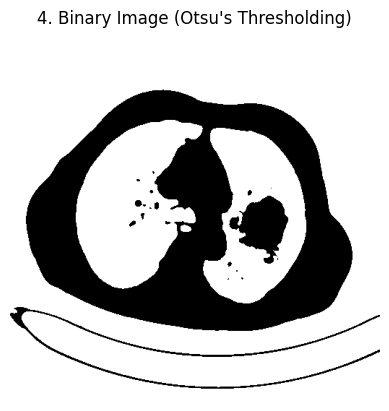

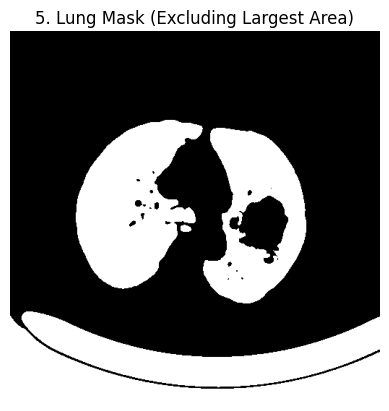

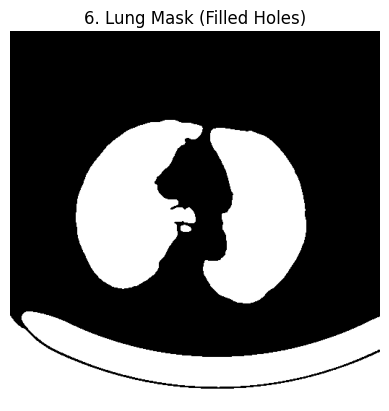

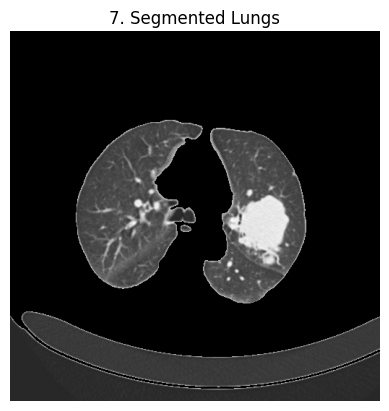

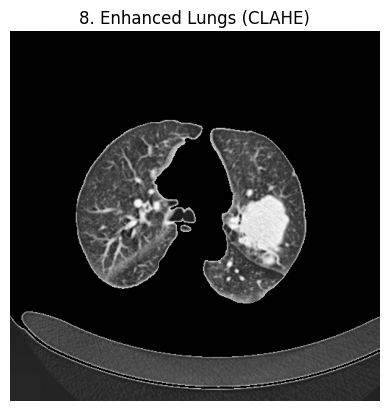

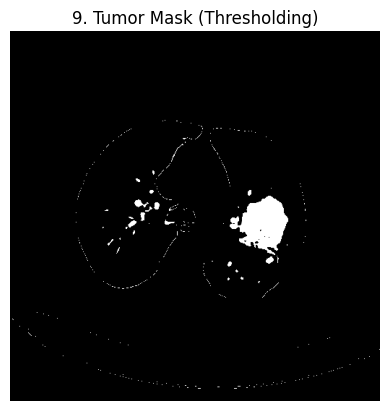

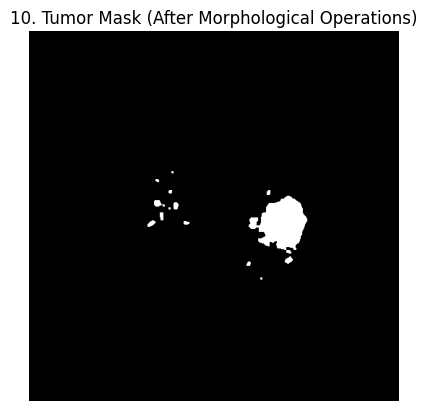

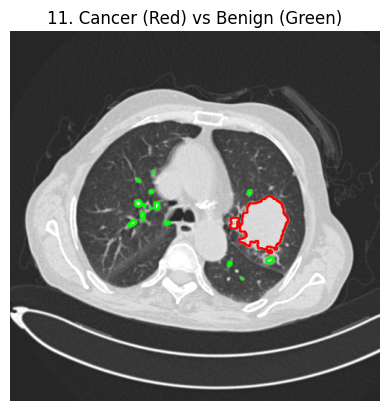

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def detect_and_classify_tumors(image_path):
    # Step 1: Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    plt.imshow(image, cmap='gray')
    plt.title("1. Original Image")
    plt.axis('off')
    plt.show()

    # Step 2: Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    plt.imshow(blurred_image, cmap='gray')
    plt.title("2. Blurred Image")
    plt.axis('off')
    plt.show()

    # Step 3: Darken the image after reducing noise
    alpha = 0.5  # Scale factor (0 < alpha < 1 to darken)
    beta = -50   # Brightness offset (negative to darken)
    darkened_image = cv2.convertScaleAbs(blurred_image, alpha=alpha, beta=beta)

    plt.imshow(darkened_image, cmap='gray')
    plt.title("3. Darkened Image")
    plt.axis('off')
    plt.show()

    # Step 4: Image Segmentation using Thresholding (Otsu's Method)
    _, binary_image = cv2.threshold(darkened_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    plt.imshow(binary_image, cmap='gray')
    plt.title("4. Binary Image (Otsu's Thresholding)")
    plt.axis('off')
    plt.show()

    # Step 5: Instance Segmentation using Connected Components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

    # Step 6: Find the largest area (excluding the background)
    areas = stats[1:, cv2.CC_STAT_AREA]  # Get areas of all labels except background
    largest_label = np.argmax(areas) + 1  # Add 1 to skip the background (label 0)

    # Step 7: Create a mask without the largest area (assumed to be the lungs)
    lung_mask = np.zeros_like(binary_image, dtype=np.uint8)
    for label in range(1, num_labels):  # Skip background (label 0)
        if label != largest_label:  # Exclude the largest area
            instance_mask = (labels == label).astype(np.uint8) * 255
            lung_mask = cv2.bitwise_or(lung_mask, instance_mask)

    plt.imshow(lung_mask, cmap='gray')
    plt.title("5. Lung Mask (Excluding Largest Area)")
    plt.axis('off')
    plt.show()

    # Step 8: Fill holes in the lung mask
    lung_mask = ndimage.binary_fill_holes(lung_mask).astype(np.uint8) * 255

    plt.imshow(lung_mask, cmap='gray')
    plt.title("6. Lung Mask (Filled Holes)")
    plt.axis('off')
    plt.show()

    # Step 9: Apply the lung mask to the original image
    segmented_lungs = cv2.bitwise_and(image, image, mask=lung_mask)

    plt.imshow(segmented_lungs, cmap='gray')
    plt.title("7. Segmented Lungs")
    plt.axis('off')
    plt.show()

    # Step 10: Enhance the segmented lungs for tumor detection
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_lungs = clahe.apply(segmented_lungs)

    plt.imshow(enhanced_lungs, cmap='gray')
    plt.title("8. Enhanced Lungs (CLAHE)")
    plt.axis('off')
    plt.show()

    # Step 11: Thresholding to detect suspicious regions
    _, tumor_mask = cv2.threshold(enhanced_lungs, 200, 255, cv2.THRESH_BINARY)

    plt.imshow(tumor_mask, cmap='gray')
    plt.title("9. Tumor Mask (Thresholding)")
    plt.axis('off')
    plt.show()

    # Step 12: Morphological operations to clean up the tumor mask
    kernel = np.ones((3, 3), np.uint8)
    tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_OPEN, kernel)  # Remove noise
    tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_CLOSE, kernel)  # Fill holes

    plt.imshow(tumor_mask, cmap='gray')
    plt.title("10. Tumor Mask (After Morphological Operations)")
    plt.axis('off')
    plt.show()

    # Step 13: Find contours of suspicious regions
    contours, _ = cv2.findContours(tumor_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 14: Classify tumors as cancer or benign based on features
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for contour in contours:
        # Calculate area of the contour
        area = cv2.contourArea(contour)

        # Calculate perimeter of the contour
        perimeter = cv2.arcLength(contour, True)

        # Calculate circularity (shape feature)
        if perimeter == 0:
            circularity = 0
        else:
            circularity = 4 * np.pi * area / (perimeter ** 2)

        # Calculate mean intensity of the region
        mask = np.zeros_like(image, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        mean_intensity = cv2.mean(enhanced_lungs, mask=mask)[0]

        # Classify based on rules (example rules)
        if area > 100 and circularity < 0.8 and mean_intensity > 150:  # Cancer
            cv2.drawContours(output_image, [contour], -1, (255, 0, 0), 2)  # Red for cancer
        else:  # Benign
            cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)  # Green for benign

    plt.imshow(output_image)
    plt.title("11. Cancer (Red) vs Benign (Green)")
    plt.axis('off')
    plt.show()

    return segmented_lungs, tumor_mask, output_image

# Example usage
image_path = '/content/Malignant case (3).jpg'  # Replace with your image path
segmented_lungs, tumor_mask, output_image = detect_and_classify_tumors(image_path)